In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as wg
import IPython.display
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import get_window
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings("ignore")
class STF:

    # init method or constructor 
    def __init__(self, data, response, window, date, cutoff, dt):
        self.data = data
        self.response = response
        self.window = window
        self.date = date
        self.cutoff = cutoff
        self.dt = dt

    def fit(self):
        
        dt = self.dt
        t = np.array(self.data[self.date])

        f = np.array(self.data[self.response])
        observed = pd.Series(f, self.data[self.date])
        self.observed = observed

        n = len(t)
        #Compute FFT
        fhat = np.fft.fft(f, n)
        # Power Spectrum
        PSD = fhat * np.conj(fhat) / n

        if self.window == "tukey":
            window = signal.tukey(len(f))
        else:
            window = get_window(self.window, len(f))

        PSD = PSD*window
        self.PSD = PSD
        # X axis of freqs
        freq = (1 / (dt*n)) * np.arange(n)
        self.freq = freq

        # Plotting first half
        L = np.arange(1, np.floor(n/2), dtype = 'int')
        self.L = L


        # Use the PSD to filter out noise
        # Filter out freqs with low power
        peaks = int(np.quantile(PSD, self.cutoff))
        indices = PSD < peaks

        # Zero out small Fourier coefs
        fhat_clean = indices * fhat
        # Inverse FFT for filtered time signal
        ffilt = np.fft.ifft(fhat_clean)

        # Filter out freqs with high power
        indices_seasonal = PSD >= peaks
        fhat_seasonal = indices_seasonal * fhat
        ffilt_seasonal = np.fft.ifft(fhat_seasonal)
     
        self.trend = pd.Series(ffilt, self.data[self.date])
    
        # This will be res.seasonal (ffilt_seasonal)
        self.seasonal = pd.Series(ffilt_seasonal, self.data[self.date])
    
        # Find the residuals 
        residual = self.data[self.response] - ffilt_seasonal.real - ffilt.real
        self.residual = residual
        self.resid = pd.Series(residual, self.data[self.date])
      
        # Initial Statistical Summary
       # print("The rmse", math.sqrt(mean_squared_error(co2["CO2"], (ffilt_seasonal + ffilt).real)))
        print("The dot product of STF seasonal and trend components is ", np.round(ffilt_seasonal.dot(ffilt)))
        return self

    def plot(self):
        t = np.array(self.data[self.date])
        freq = self.freq
        L = self.L
        PSD = self.PSD

        
        fig, axes = plt.subplots(5, 1)

        plt.sca(axes[0])
        plt.plot(freq[L], PSD[L], color = 'c')
        plt.xlim(freq[L[0]], freq[L[-1]])
        plt.xlabel("Freq (1/yr)")
        plt.ylabel("FFT")
    

        plt.sca(axes[1])
        plt.plot(t, self.observed, color = 'c')
        plt.xlim(t[0], t[-1])
        plt.xlabel("Year")
        plt.ylabel("Response")


        plt.sca(axes[2])
        plt.plot(t, self.trend, color = 'c')
        plt.xlim(t[0], t[-1])
        plt.ylabel("Trend")
        plt.xticks(fontsize = 'small')

        plt.sca(axes[3])
        # This will be res.seasonal (ffilt_seasonal)
        plt.plot(t, self.seasonal, color = "c")
        plt.xlim(t[0], t[-1])
        plt.ylabel("Season")


        # Find the residuals 
        plt.sca(axes[4])
        plt.scatter(t, self.residual, color = "c")
        plt.ylabel("Resid")
        plt.xlim(t[0], t[-1])

        plt.show()
        return self
    

    



The dot product of STF seasonal and trend components is  (-0-0j)


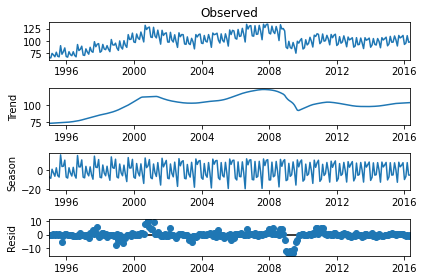

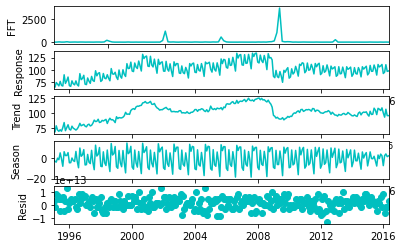

In [67]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.datasets import elec_equip as ds

# Test stf vs stl on elec_equip data
elec_equip = ds.load().data
stl = STL(elec_equip, period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
elec_equip = elec_equip.reset_index()
elec_equip["value"] = elec_equip["STS.M.I7.W.TOVT.NS0016.4.000"]
stf = STF(elec_equip, "value", "tukey", "DATE", .90, 1/12)
res = stf.fit()
res.plot()

The dot product of STF seasonal and trend components is  (-0+0j)


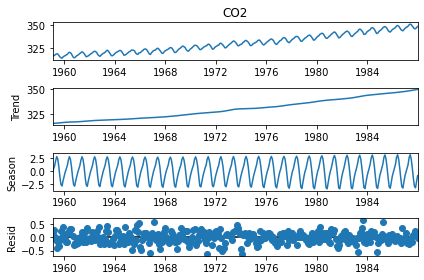

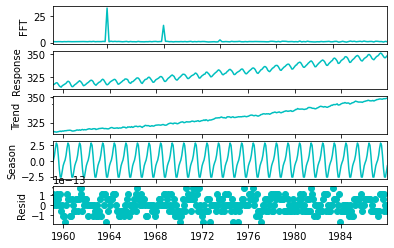

'hanning'

In [68]:
co2 =pd.read_csv('../data/co2.csv', index_col='date', parse_dates=True, squeeze=True)

stl = STL(co2, seasonal=13)
res = stl.fit()
fig = res.plot()

co2 = pd.read_csv("../data/co2.csv")
co2["date"] = pd.to_datetime(co2["date"], format = '%Y-%m-%d')
stf = STF(co2, "CO2", "hanning", "date", .99, 1/12)
res = stf.fit()
fig = res.plot()
res.window

The dot product of STF seasonal and trend components is  (685758309+0j)


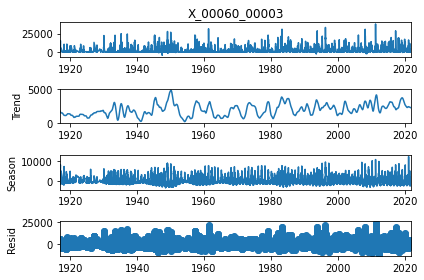

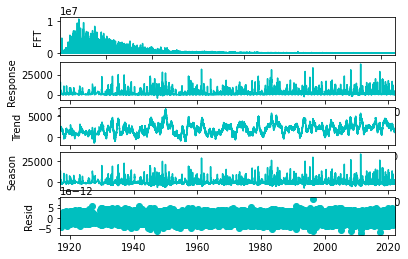

In [69]:
streamflow = covid = pd.read_csv('../data/big_muddy_streamflow.csv', index_col='Date', parse_dates=True, squeeze=True)
stl = STL(streamflow["X_00060_00003"], period = 365)
res = stl.fit()
fig = res.plot()

streamflow = streamflow.reset_index()
streamflow["Date"] = pd.to_datetime(streamflow["Date"], format = '%Y-%m-%d')
streamflow = streamflow.fillna(0)
stf = STF(streamflow, "X_00060_00003", "tukey", "Date", 0.5, 1/365)
res = stf.fit()
res.plot()